### Сравнение времени регистрации транзакций при подаче через торговый терминал QUIK
Цель: сравнить время регистрации тарнзакций на Московской бирже, отправляемых через торговый терминал QUIK используя три способа:

1. Подключение торговым терминалом QUIK из внутренней сети напрямую к серверу QUIK
2. Подключение торговым терминалом QUIK из внутренней сети через сервер доступа QUIK
3. Подключение торговым терминалом QUIK из интернета через сервер доступа QUIK

*Замер времени регистрации транзакций осуществлялся используя скрипты, написанные на lua.
Скрипты находятся в репозитории в папке lua. 


#### Версии:
<ul>
<li>python: 3.10.1</li>
<li>pandas version: 1.3.5</li>
<li>numpy version: 1.22.0</li>
<li>pyplot version: 3.5.1</li>
<li>seaborn version: 0.11.2</li>
</ul>

In [1]:
# импортируем необходимые модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(798)
sns.set()

In [2]:
'''
Загружаем данные:
df_server: датафрейм для кейса 1
df_as: датафрейм для кейса 2
df_internet: датафрейм для кейса 3
'''
df_server=pd.read_csv('.\\stat\\server.txt',sep=';',header=0)
df_as=pd.read_csv('.\\stat\\access_server.txt',sep=';',header=0)
df_internet=pd.read_csv('.\\stat\\internet.txt',sep=';',header=0)

In [3]:
# смотрим структуру датафрейма
print(df_server.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              400 non-null    object 
 1   trans_id          400 non-null    int64  
 2   local_time        400 non-null    int64  
 3   order_num         400 non-null    int64  
 4   order_start_time  400 non-null    float64
 5   order_stop_time   400 non-null    float64
 6   delta_time        400 non-null    float64
 7   Stock             400 non-null    object 
 8   date              400 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 28.2+ KB
None


#### Описание полей:
<ul>
<li>type: тип транзакции 
    <ul>
    <li>send_order-отправить транзакцию "заявка на покупку" на биржу</li>
    <li>kill_order: отправить транзакцию "снять заявку" на биржу</li>
    </ul>
<li>trans_id: уникальный номер транзакции</li>
<li>local_time: время выставления транзакции</li>
<li>order_num: номер заявки на регистрацию на бирже</li>
<li>order_start_time: время до отправки транзакции</li>
<li>order_stop_time: время после ответа об успешной регистрации заявки</li>
<li>delta_time: разница между order_start_time и order_stop_time по модулю</li>
<li>Stock: рынок, по которому отправлялись транзакции</li>
<li>date: дата отправки транзакций</li>
</ul>


In [4]:
# функция для подготовки данных к анализу
def f_df_transform(df):
    df[['date','local_time']]=df[['date','local_time']].astype(str)
    df['len_local_time']=df.local_time.map(len)
    df.loc[df['len_local_time']==5,'local_time']='0'+df['local_time']
    df.loc[df['len_local_time']==4,'local_time']='00'+df['local_time']
    df.loc[df['len_local_time']==3,'local_time']='000'+df['local_time']
    df.loc[df['len_local_time']==2,'local_time']='0000'+df['local_time']
    df.loc[df['len_local_time']==1,'local_time']='00000'+df['local_time']

    df['date_time']=df['date']+' '+df['local_time']
    df['date_time']=pd.to_datetime(df['date_time'],format='%Y%m%d %H%M%S')
    df['seconds']=df.delta_time
    df=df.set_index('date_time')
    df['date_time']=df.index
    df.index.name=None
    df=df.sort_values(by=['date_time'])
    df=df.drop(['Stock','trans_id','local_time','len_local_time','delta_time','date','order_start_time','order_stop_time','date_time'],axis=1)
    return df


In [5]:
# готовим данные к анализу используя функцию f_df_transform()
df_server=f_df_transform(df_server)
df_as=f_df_transform(df_as)
df_internet=f_df_transform(df_internet)

In [6]:
''' смотим на примере датафрейма df_server что получилось
название поля delta_time заменено на поле seconds
seconds: время полного цикла обработки транзакции '''
print(df_server.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 2022-04-12 12:06:01 to 2022-04-12 12:07:02
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       400 non-null    object 
 1   order_num  400 non-null    int64  
 2   seconds    400 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.5+ KB
None


In [7]:
# используя метод describe() смотрим, что получилось
print(f'\nServer transaction time result in seconds:\n {df_server.describe().seconds}')
print(f'\nAccess server transaction time result in seconds:\n {df_as.describe().seconds}')
print(f'\nInternet transaction time result in seconds:\n {df_internet.describe().seconds}')


Server transaction time result in seconds:
 count    400.000000
mean       0.019820
std        0.011033
min        0.007000
25%        0.012000
50%        0.015000
75%        0.024000
max        0.097000
Name: seconds, dtype: float64

Access server transaction time result in seconds:
 count    400.000000
mean       0.040160
std        0.020123
min        0.009000
25%        0.030000
50%        0.034000
75%        0.050000
max        0.119000
Name: seconds, dtype: float64

Internet transaction time result in seconds:
 count    398.000000
mean       0.077693
std        0.025429
min        0.036000
25%        0.058000
50%        0.077000
75%        0.091000
max        0.255000
Name: seconds, dtype: float64


In [8]:
# добавляем новое поле с категорией
'''
server: соответствует кейсу 1
as: соответствует кейсу 2
internet: соответствует кейсу 3
'''
df_server['id']='server'
df_as['id']='as'
df_internet['id']='internet'

# объединяем все данные в один датафрейм
df=pd.concat([df_server,df_as,df_internet])

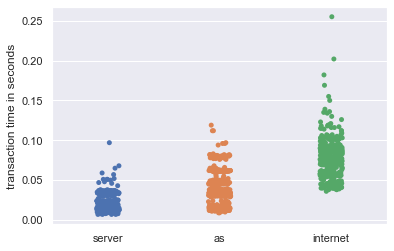

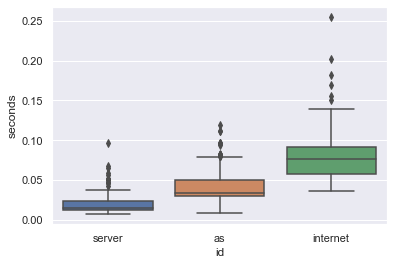

In [9]:
# посторим график, на котором по оси y - время регистрации транзакции, а на оси x - категория из условаия 3ех кейсов
sns.set()
#_=sns.swarmplot(df.id,df.seconds)
_=sns.stripplot(data=df, x='id',y='seconds')
_=plt.xlabel('')
_=plt.ylabel('transaction time in seconds')
plt.show()

_=sns.boxplot(data=df,x=df.id,y=df.seconds)
plt.show()

Рассмотрев графики видим, что время регистрации транзакций через разные компоненты отличается.
Рассматриваемая велечина seconds является количественной.
Напишем функцию для построения эмпирической кумулятивной функции распределения исходя из наших данных.

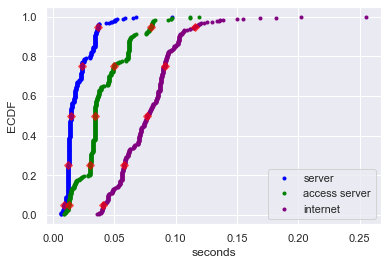

In [10]:
# функция для подготовки данных для построения графика кумулятивной функции распределения
def ecdf(data):
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return x,y

# создаем массивы с данными
serv_seconds=df[df.id=='server'].seconds
as_seconds=df[df.id=='as'].seconds
int_seconds=df[df.id=='internet'].seconds

# используя функию ecdf() получаем данные для построения графиков кумулятивных функций распределения
x_s,y_s=ecdf(serv_seconds)
x_as,y_as=ecdf(as_seconds)
x_int,y_int=ecdf(int_seconds)

# найдем процентили для каждого из массивов
percentiles=np.array([5,25,50,75,95])
ptiles_s=np.percentile(serv_seconds,percentiles)
ptiles_as=np.percentile(as_seconds,percentiles)
ptiles_int=np.percentile(int_seconds,percentiles)

# построим график эмпирической кумулятивной функции и отметим процентили для каждого из кейсов
_=plt.plot(x_s,y_s,marker='.',linestyle='none',color='blue')
_=plt.plot(x_as,y_as,marker='.',linestyle='none',color='green')
_=plt.plot(x_int,y_int,marker='.',linestyle='none',color='purple')
_=plt.plot(ptiles_s,percentiles/100,marker='D',color='red',linestyle='none',alpha=0.6)
_=plt.plot(ptiles_as,percentiles/100,marker='D',color='red',linestyle='none',alpha=0.6)
_=plt.plot(ptiles_int,percentiles/100,marker='D',color='red',linestyle='none',alpha=0.6)
_=plt.legend(('server','access server','internet'),loc='lower right')
_=plt.xlabel('seconds')
_=plt.ylabel('ECDF')

In [11]:
print(f'50% регистрации всех транзакций для кейса 1 (график server) составляет по времени менее: {ptiles_s[2]} секунды')
print(f'50% регистрации всех транзакций для кейса 2 (график access server) составляет по времени менее: {ptiles_as[2]} секунды')
print(f'50% регистрации всех транзакций для кейса 3 (график internet) составляет по времени менее: {ptiles_int[2]} секунды')

50% регистрации всех транзакций для кейса 1 (график server) составляет по времени менее: 0.01500000001397 секунды
50% регистрации всех транзакций для кейса 2 (график access server) составляет по времени менее: 0.0340000000142025 секунды
50% регистрации всех транзакций для кейса 3 (график internet) составляет по времени менее: 0.077000000000226 секунды


Построим график функции плотности вероятности для среднего значения времени регистрации транзакции mean().
<br>Для этого напишем две функции bootstrap_replicate() и draw_bs_reps().

In [12]:
''' функция bootstrap_replicate смоделирует рандомную выборку значений массива data 
 и вернет результат переданной в параметры функции func '''
def bootstrap_replicate(data,func):
    bs_sample=np.random.choice(data,len(data))
    return func(bs_sample)

# пример расчета mean() для массива serv_seconds эмпирического и смоделированного
print(f'Эмпирическое mean() времени регистрации транзакций df_server: {np.mean(serv_seconds)} seconds')
print(f'Смоделированное mean() времени регистрации транзакций df_server: {bootstrap_replicate(serv_seconds,np.mean)} seconds')

Эмпирическое mean() времени регистрации транзакций df_server: 0.019820000000472654 seconds
Смоделированное mean() времени регистрации транзакций df_server: 0.02037749999901279 seconds


In [13]:
''' функция draw_bs_reps смоделирует массив дынных нужной статистической величины (например mean() или std()) 
 на основании функции bootstrap_replicate() равное size количеству раз '''
def draw_bs_reps(data,func,size=1):
    bs_replicates=np.empty(size)
    for i in range(size):
        bs_replicates[i]=bootstrap_replicate(data,func)
    return bs_replicates


In [14]:
''' смоделируем массив данных среднего времени регистрации транзакций mean() для каждого из кейсов
 для этого используем 3 массива serv_seconds, as_seconds и int_seconds и функцию  draw_bs_reps() '''
serv_bs_replicates=draw_bs_reps(serv_seconds,func=np.mean,size=10000)
as_bs_replicates=draw_bs_reps(as_seconds,func=np.mean,size=10000)
int_bs_replicates=draw_bs_reps(int_seconds,func=np.mean,size=10000)



Построим график функции плотности вероятности для среднего значения времени регистрации транзакции mean()
и добавим 95% доверительный интервал на график.
<br>Также сравним стандартную ошибку среднего эмпирических данных и стандартное отклонение среднего, 
полученного из смоделированных массивов.

In [15]:
''' функия построения графика функции плотности вероятности для среднего значения времени регистрации
транзакции mean() и расчета 95% доверительного интервала '''
def f_plot(data,repl_data,label):
    bin_count=int(1+3.122*np.log(len(data))) # рассчитаем кол-во столбцов гистограммы по правилу Стерджеса
    col = (np.random.random(), np.random.random(), np.random.random())
    sns.displot(repl_data,stat='probability',bins=bin_count,color=col)
    # найдем 95% доверительный интервал
    ptiles_bs_replicates=np.percentile(repl_data,np.array([2.5,97.7]))
    _=plt.axvline(x=ptiles_bs_replicates[0],ymin=0,ymax=1,color='red',linestyle='--')
    _=plt.axvline(x=ptiles_bs_replicates[1],ymin=0,ymax=1,color='red',linestyle='--')
    _=plt.xlabel("mean transaction time (seconds)")
    _=plt.ylabel("probability density function")
    _=plt.title(label)
    plt.show()
    print(f"{label} 95% доверительный интервал среднего в секундах: {ptiles_bs_replicates} ")
    print(f"{label}  стандартная ошибка среднего эмпирических данных: {np.std(data)/np.sqrt(len(data))} ")
    print(f"{label}  стандартная ошибка среднего смоделированного массива: {np.std(repl_data)} ")
    return

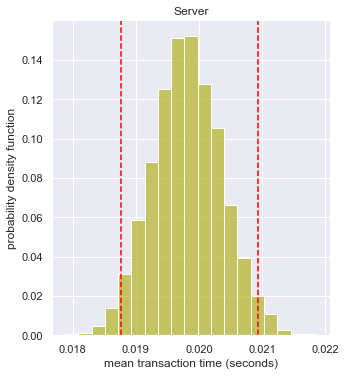

Server 95% доверительный интервал среднего в секундах: [0.01877   0.0209325] 
Server  стандартная ошибка среднего эмпирических данных: 0.0005509482734900955 
Server  стандартная ошибка среднего смоделированного массива: 0.0005461845562805818 


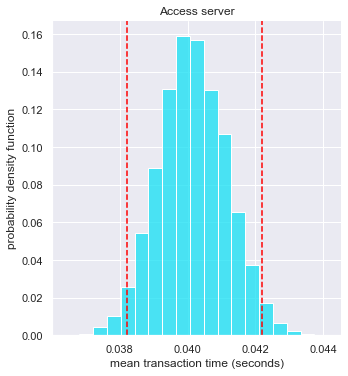

Access server 95% доверительный интервал среднего в секундах: [0.03820744 0.04218756] 
Access server  стандартная ошибка среднего эмпирических данных: 0.0010049121853226187 
Access server  стандартная ошибка среднего смоделированного массива: 0.0010050621825257171 


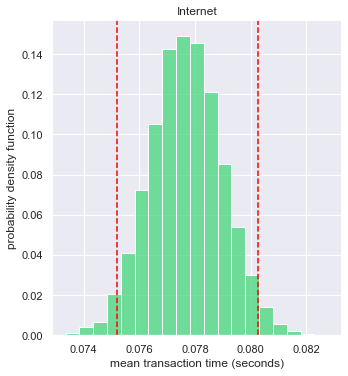

Internet 95% доверительный интервал среднего в секундах: [0.07518574 0.08027387] 
Internet  стандартная ошибка среднего эмпирических данных: 0.001273045442912571 
Internet  стандартная ошибка среднего смоделированного массива: 0.0012865330910197836 


In [16]:
f_plot(data=serv_seconds,repl_data=serv_bs_replicates,label='Server')
f_plot(data=as_seconds,repl_data=as_bs_replicates,label='Access server')
f_plot(data=int_seconds,repl_data=int_bs_replicates,label='Internet')

## Заключение
В текущем проекте выполнен следующий спектр работ:
<ol>
<li>Определена цель исследования</li>
<li>Собраны данные для анализа используя язык программирования lua и торговую систему</li>
<li>Данные подготовлены к анализу</li>
<li>Проведено исследование и визуализация данных</li>
<li>Построен график эмпирической кумулятивной функции и процентили</li>
<li>Смоделированны данные для построения графиков функции плотности вероятности для среднего значения времени регистрации транзакции и рассчитан 95% доверительный интервал</li>
<li>Получены значения стандартной ошибки среднего эмпирических данных и смоделированного массива</li>
</ol>

<br><b>Подведем итог</b>
<br>В результате сравнения времени регистрации тарнзакций на Московской бирже, отправляемых через торговый терминал QUIK, было выявленно явное преимущество в скорости при подлючении терминалом QUIK напрямую к серверу.
<br>Подключение из внутренней сети через сервер доступа и из интернета вносит задержки при регистрации транзакций, т.к. появляются промежуточные звенья в маршруте транзакций, а именно сеть и сервер доступа.
